In [1]:
!pip install rdkit-pypi
!pip install pandas seaborn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 14.3 MB/s eta 0:00:00


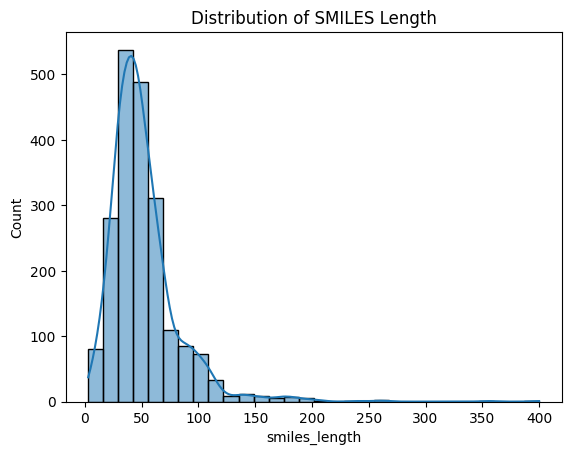

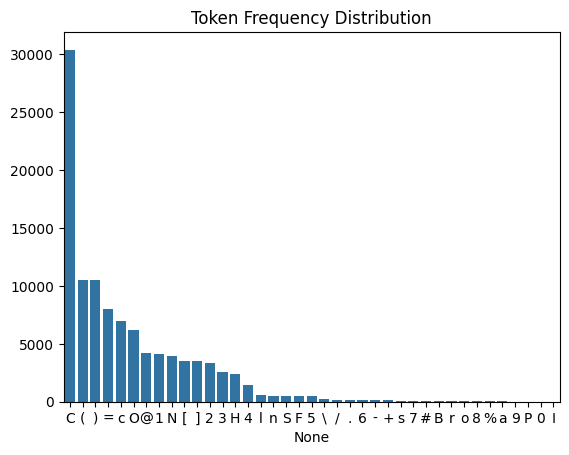

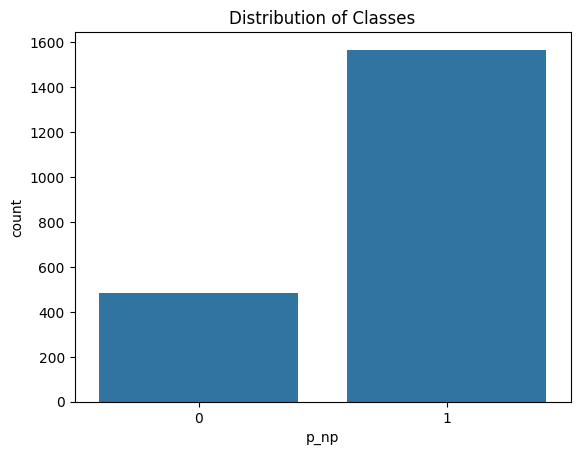

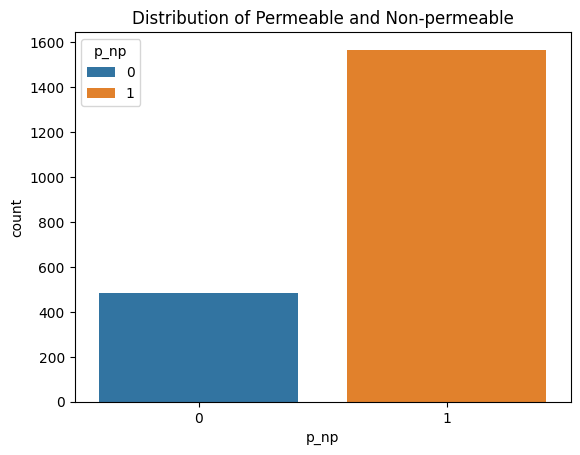

In [3]:
# 1
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('BBBP.csv')

df['smiles_length'] = df['smiles'].apply(lambda x: len(x))
sns.histplot(df['smiles_length'], bins=30, kde=True)
plt.title('Distribution of SMILES Length')
plt.show()

all_tokens = [token for smiles in df['smiles'] for token in smiles]
token_counts = pd.Series(all_tokens).value_counts()
sns.barplot(x=token_counts.index, y=token_counts.values)
plt.title('Token Frequency Distribution')
plt.show()

sample_data = df[['name', 'p_np', 'smiles']].head(5)

sns.countplot(x='p_np', data=df)
plt.title('Distribution of Classes')
plt.show()

sns.countplot(x='p_np', hue='p_np', data=df)
plt.title('Distribution of Permeable and Non-permeable')
plt.show()


In [4]:
sample_data

,name,p_np,smiles
0,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [20]:
# 2
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df = pd.read_csv('BBBP.csv')

smiles_encoder = OneHotEncoder(sparse_output=False, dtype=int, handle_unknown='ignore')
column_transformer = ColumnTransformer([('smiles', smiles_encoder, ['smiles'])])
pipeline = Pipeline(steps=[('preprocessor', column_transformer)])

X = pipeline.fit_transform(df)

class SimpleFCModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleFCModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

X_train, X_test, y_train, y_test = train_test_split(X, df['p_np'], test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

input_size = X_train.shape[1]
hidden_size = 128
output_size = 1

model = SimpleFCModel(input_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(loss.item())

model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_binary = (y_pred > 0.5).float()
    accuracy = accuracy_score(y_test, y_pred_binary.numpy())

print(f'Accuracy on the test set: {accuracy * 100:.2f}%')


0.7110069394111633
0.7079435586929321
0.7049616575241089
0.7020223736763
0.6990988850593567
0.6961663961410522
0.6931894421577454
0.690134584903717
0.6869703531265259
0.6836658716201782
0.6801913976669312
0.6765210628509521
0.6726312637329102
0.6685000658035278
0.6641061902046204
0.6594328284263611
0.6544668674468994
0.6491996049880981
0.6436170339584351
0.6376878023147583
Accuracy on the test set: 76.83%


In [6]:
# 3
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from torch.utils.data import DataLoader, TensorDataset

df = pd.read_csv('BBBP.csv')

smiles_encoder = OneHotEncoder(sparse_output=False, dtype=int, handle_unknown='ignore')
column_transformer = ColumnTransformer([('smiles', smiles_encoder, ['smiles'])])
pipeline = Pipeline(steps=[('preprocessor', column_transformer)])

X = pipeline.fit_transform(df)

X_train, X_test, y_train, y_test = train_test_split(X, df['p_np'], test_size=0.2, random_state=42)

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

class MolLSTMImproved(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.5):
        super(MolLSTMImproved, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(hidden_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.sigmoid(out)
        return out


input_size = X_train.shape[1]
hidden_size = 64
num_layers = 10
output_size = 1

model = MolLSTMImproved(input_size, hidden_size, num_layers, output_size, dropout_rate=0.5)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

num_epochs = 300
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_binary = (y_pred > 0.5).float()
    accuracy = accuracy_score(y_test, y_pred_binary.numpy())

print(f'Accuracy on the test set: {accuracy * 100:.2f}%')


Accuracy on the test set: 76.83%


In [7]:
# 4
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd

df = pd.read_csv('BBBP.csv')

smiles_encoder = OneHotEncoder(sparse_output=False, dtype=int, handle_unknown='ignore')
column_transformer = ColumnTransformer([('smiles', smiles_encoder, ['smiles'])])
pipeline = Pipeline(steps=[('preprocessor', column_transformer)])

X = pipeline.fit_transform(df)

X_train, X_test, y_train, y_test = train_test_split(X, df['p_np'], test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

class MolImprovedBiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.5):
        super(MolImprovedBiLSTM, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=dropout_rate)
        self.batch_norm1 = nn.BatchNorm1d(hidden_size * 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(hidden_size * 2, 256)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)
        self.batch_norm3 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.relu3 = nn.ReLU()
        self.batch_norm4 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, _ = self.bilstm(x)
        out = self.batch_norm1(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.dropout1(out)
        out = self.batch_norm2(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        out = self.batch_norm3(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.batch_norm4(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        return out

input_size = X_train.shape[1]
hidden_size = 128
num_layers = 10
output_size = 1

bilstm_model = MolImprovedBiLSTM(input_size, hidden_size, num_layers=2, output_size=1, dropout_rate=0.5)

optimizer_bilstm = optim.Adam(bilstm_model.parameters(), lr=0.001)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

num_epochs = 200
for epoch in range(num_epochs):
    bilstm_model.train()
    for batch_X, batch_y in train_loader:
        optimizer_bilstm.zero_grad()
        outputs = bilstm_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_bilstm.step()

optimizer_bilstm2 = optim.Adam(bilstm_model.parameters(), lr=0.0001)

num_epochs = 100
for epoch in range(num_epochs):
    bilstm_model.train()
    for batch_X, batch_y in train_loader:
        optimizer_bilstm.zero_grad()
        outputs = bilstm_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer_bilstm.step()

bilstm_model.eval()
with torch.no_grad():
    y_pred_bilstm = bilstm_model(X_test_tensor)
    y_pred_binary_bilstm = (y_pred_bilstm > 0.5).float()
    accuracy_bilstm = accuracy_score(y_test, y_pred_binary_bilstm.numpy())

print(f'Accuracy on the test set (BiLSTM): {accuracy_bilstm * 100:.2f}%')


Accuracy on the test set (BiLSTM): 76.83%


In [15]:
# 5 for simpleFC
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, ClassifierMixin

df = pd.read_csv('BBBP.csv')

smiles_encoder = OneHotEncoder(sparse_output=False, dtype=int, handle_unknown='ignore')
column_transformer = ColumnTransformer([('smiles', smiles_encoder, ['smiles'])])
pipeline = Pipeline(steps=[('preprocessor', column_transformer)])
X = pipeline.fit_transform(df)

class SimpleFCModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleFCModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

class PyTorchWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model, criterion, optimizer, num_epochs=20):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs

    def fit(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

        for epoch in range(self.num_epochs):
            self.model.train()
            self.optimizer.zero_grad()
            outputs = self.model(X_tensor)
            loss = self.criterion(outputs, y_tensor)
            loss.backward()
            self.optimizer.step()

        return self

    def predict(self, X):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        self.model.eval()
        with torch.no_grad():
            y_pred = self.model(X_tensor)
            y_pred_binary = (y_pred > 0.5).float().numpy()
        return y_pred_binary

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(df['p_np'].values, dtype=torch.float32).view(-1, 1)

input_size = X.shape[1]
hidden_size = 128
output_size = 1
model = SimpleFCModel(input_size, hidden_size, output_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

pytorch_model = PyTorchWrapper(model, criterion, optimizer, num_epochs=200)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracies = cross_val_score(pytorch_model, X, df['p_np'], cv=cv, scoring='accuracy')

for fold, accuracy in enumerate(accuracies, 1):
    print(f'Fold {fold} Accuracy: {accuracy * 100:.2f}%')

print(f'Mean Accuracy: {accuracies.mean() * 100:.2f}%')
print(f'Standard Deviation: {accuracies.std() * 100:.2f}%')


Fold 1 Accuracy: 23.41%
Fold 2 Accuracy: 23.41%
Fold 3 Accuracy: 23.66%
Fold 4 Accuracy: 23.66%
Fold 5 Accuracy: 23.66%
Mean Accuracy: 23.56%
Standard Deviation: 0.12%


__6__:<br>
when applying RNN and Bidirectional RNN to a SMILES dataset:<br>

RNN:<br>

In the context of SMILES strings, which represent molecular structures, RNN processes the sequence of characters one by one, considering the information from the previous characters in the string.<br>
It captures dependencies in the SMILES strings in a unidirectional manner, meaning it primarily relies on the information from the beginning of the string to make predictions for subsequent characters.<br>
SMILES strings often have a well-defined order of characters representing the molecular structure, making unidirectional processing sufficient for certain tasks.<br>
Bidirectional RNN:<br>

Bidirectional RNN, in the context of SMILES, processes the sequence both forward and backward, providing a more comprehensive understanding of the structural dependencies.<br>
Since SMILES strings encode information about the molecular structure bidirectionally (from the start and end towards the center), Bidirectional RNN can potentially capture dependencies more effectively.<br>
It might be particularly beneficial when dealing with complex molecular structures where information from both ends of the SMILES string is relevant for understanding the overall structure.<br>